# Maximum $v_i$ versus $F_\mathrm{app}$ and $p_\mathrm{cons}$

 - We analyze the Single Random Swap (SRS) protocol.
 - The network topology is a ($d$,$k$)-tree. In particular, the results shown here correspond to a ($2$,$3$)-tree. This can also be viewed as a dumbbell network.

Here, we only look at the users (lowest-level nodes in the tree).

In [2]:
import numpy as np
import numpy.matlib as npm
import json
import matplotlib.pyplot as plt
from matplotlib import rc
import copy
import warnings
import scipy
from scipy import sparse
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmn
import importlib as imp
import os
import random

import main_cd as main
import main_cd_plots as pltm
import validation_tests as tests

# Dark background?
dark = False
if dark==True:
    plt.style.use('dark_background')
else:
    plt.style.use('default')
    
# Latex
from matplotlib import rc
#rc('text', usetex=False)
#plt.rcParams.update({
#    'text.usetex': False,
#    'text.latex.preamble': r'\usepackage{amsfonts}'
#})

# Save figures in the notebook with decent quality
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

# Create figures directory if needed
try:
    os.mkdir('figs')
except FileExistsError:
    pass

In [3]:
imp.reload(main)

# Topology
protocol = 'srs'
d = 2
k = 3
n = int(str(d)+str(k)) # This variable is only for data storage purposes
A = main.adjacency_tree(d,k)
topology = 'tree'


# Hardware
p_gen = 0.9
p_swap = 1
qbits_per_channel = 5
coherence_time = 2000


# Software/application
q_swap_vec = np.arange(0,1.01,0.02) #np.append( np.arange(0,0.5,0.01), np.arange(0.5,1.01,0.05) )
max_links_swapped = 4
p_cons = 0.225


# Cutoff calculation
F_new = 0.95


# Simulation
data_type = 'avg'
N_samples = 10000
tolerance = 1e-2
steady_state_window = None  # NOTE: steady state finder is disabled
                            # to speed up the calculations.
steady_state_force_find = True
randomseed = 2
np.random.seed(randomseed)

# Varying arrays
user = 2
F_app_vec = np.arange(0.5,0.8,0.05)
p_cons_vec = np.arange(0,0.301,0.025)

In [4]:
# #####################
# ## LOAD DATA ##
# #####################


if steady_state_window is None:
    print('WARNING: presence of steady state not checked')

phys_deg = main.physical_degrees(A)
number_of_nodes = len(A)

data = [[_ for _ in p_cons_vec] for _ in F_app_vec]
data_q = [[_ for _ in p_cons_vec] for _ in F_app_vec]
data_std = [[_ for _ in p_cons_vec] for _ in F_app_vec]
for F_app_idx, F_app in enumerate(F_app_vec):
    for p_cons_idx, p_cons in enumerate(p_cons_vec):

        # F_app-dependent quantities
        cutoff = np.floor( -coherence_time * np.log(3*(
                    (4*F_app-1)/3)**(1/max_links_swapped)/(4*F_new-1)) )
        total_time = cutoff*10
        if steady_state_window is None:
            pass
        else:
            steady_state_window = 2*min(qbits_per_channel,cutoff)

        # Load data for each value of q
        try:
            data_vs_q = [None for _ in q_swap_vec]
            data_std_vs_q = [None for _ in q_swap_vec]
            for q_idx, q_swap in enumerate(q_swap_vec):
                # Data
                _data = main.load_data_cd(protocol, data_type, topology, n, p_gen, q_swap,
                                    p_swap, p_cons, cutoff, max_links_swapped, qbits_per_channel,
                                    N_samples, total_time, randomseed)

                # Check steady state
                if steady_state_window is None:
                    # If no window is specified, we assume the steady state was reached
                    data_vs_q[q_idx] = _data['avg_vneighs'][user][-1]
                    data_std_vs_q[q_idx] = 2*_data['std_vneighs'][user][-1]/np.sqrt(N_samples)
                    pass
                else:
                    if steady_state_force_find: # Ensure that we find a steady state
                                                # by making errors progressively large
                        vneighs_ss_idx = None
                        error_increase = 1
                        while vneighs_ss_idx is None:
                            error_vneigh = error_increase*min(phys_deg[user]*qbits_per_channel,
                                                number_of_nodes)/np.sqrt(N_samples)
                            vneighs_ss_idx = main.find_steady_state(_data['avg_vneighs'][user], error_vneigh,
                                                                    steady_state_window,
                                                                    window_type='shrinking')
                            error_increase = error_increase+0.1
                    else:                  
                        error_vneigh = min(phys_deg[user]*qbits_per_channel,
                                            number_of_nodes)/np.sqrt(N_samples)
                        vneighs_ss_idx = main.find_steady_state(_data['avg_vneighs'][user], error_vneigh,
                                                                steady_state_window,
                                                                window_type='shrinking')
                    if vneighs_ss_idx is not None:
                        data_vs_q[q_idx] = _data['avg_vneighs'][user][-1]
                        data_std_vs_q[q_idx] = 2*_data['std_vneighs'][user][-1]/np.sqrt(N_samples)


            max_value = max(data_vs_q)
            max_index = data_vs_q.index(max_value)
            data[F_app_idx][p_cons_idx] = max_value
            data_std[F_app_idx][p_cons_idx] = data_std_vs_q[max_index]
            data_q[F_app_idx][p_cons_idx] = q_swap_vec[max_index]
        except:
            data[F_app_idx][p_cons_idx] = 0
            data_std[F_app_idx][p_cons_idx] = 0
            data_q[F_app_idx][p_cons_idx] = 0

#        if round(p_cons,3) in [0.100,0.300]:
#            print(round(F_app,3),round(p_cons,3),round(data[F_app_idx][p_cons_idx],3))

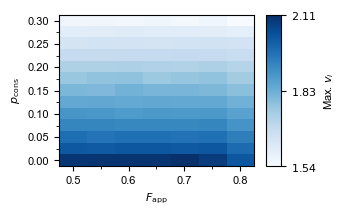

In [5]:
x = F_app_vec
y = p_cons_vec

z = data

minz = np.min(z)

maxstd = np.max(data_std)

imp.reload(main)

filename = 'figs/maxvneighs_vs_q_%s_%d-%d-tree_user%d'%(protocol,d,k,user)
filename += '_pgen%.3f_pswap%.3f_qbitsperchannel%d'%(p_gen,p_swap,qbits_per_channel)
filename += '_coherencetime%d_maxlinksswapped%d'%(coherence_time,max_links_swapped)
filename += '_Fnew%.2f_Nsamples%d'%(F_new,N_samples)
filename += '_tolerance%s_randomseed%s_maxstderr%.3f.pdf'%(tolerance,randomseed,maxstd)

main.plot_colormap(x,y,z,'$F_\mathrm{app}$','$p_\mathrm{cons}$',r'Max. $v_i$',
                cbar_max=1, cbar_min=minz, annotate_min=False, annotate_max=False,
                annotation_error=maxstd, filename=filename)

In [10]:
for F_app_idx, F_app in enumerate(F_app_vec):
    print('--','%.2f'%F_app,'--')
    for p_cons_idx, p_cons in enumerate(p_cons_vec):
        if ((round(F_app,2)==0.8 or round(F_app,2)==0.5)
            and (round(p_cons,2)==0.1 or round(p_cons,2)==0.3)):
            print('%.2f'%p_cons,'%.3f'%z[F_app_idx][p_cons_idx], '(%.3f)'%data_std[F_app_idx][p_cons_idx])

-- 0.50 --
0.10 1.886 (0.014)
0.30 1.563 (0.013)
-- 0.55 --
-- 0.60 --
-- 0.65 --
-- 0.70 --
-- 0.75 --
-- 0.80 --
0.10 1.857 (0.014)
0.30 1.544 (0.013)


0.5 0.0


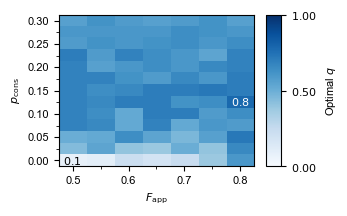

In [11]:
x = F_app_vec
y = p_cons_vec

z = data_q
cbar_label = r'Optimal $q$'

imp.reload(main)

main.plot_colormap(x,y,z,'$F_\mathrm{app}$','$p_\mathrm{cons}$',cbar_label,
                cbar_max=1, cbar_min=0, annotate_min=True, annotate_max=True,
                filename=None)